In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

<AxesSubplot:>

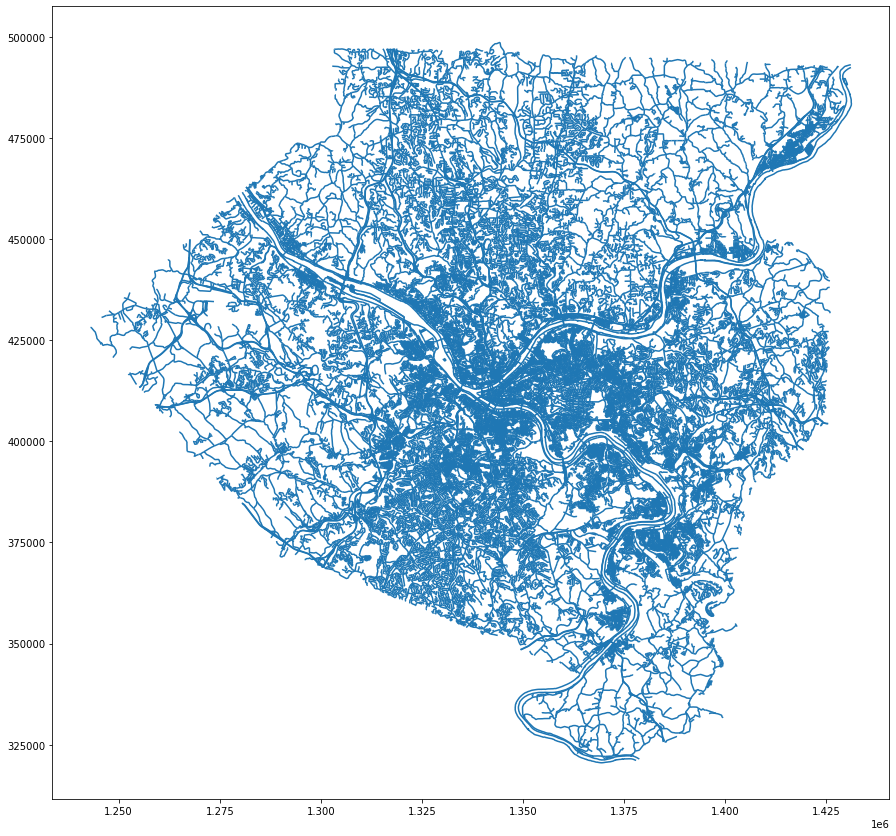

In [12]:
# street_map = gpd.read_file('kx-pittsburgh-pa-neighborhoods-SHP/pittsburgh-pa-neighborhoods.shp')
street_map = gpd.read_file('AlleghenyCounty_StreetCenterlines202204/AlleghenyCounty_StreetCenterlines202204.shp')

fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)